In [1]:


import pandas as pd
import numpy as np
import tkinter as tk
from tkinter.filedialog import askdirectory
import os
import cv2
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

"""Function to import training data set. When run, point to the parent folder containing all subfolders for each class."""
def import_data():
    
    root = tk.Tk()
    #arr = np.empty((0,100,100,3), int)
    arr=[]
    y=[]
    name = askdirectory(title = "Select folder")
    root.update()
    root.withdraw()
    print(name)
    sub_folders=os.listdir(name)
    for folder in sub_folders:
        print("Currently reading:",name+"/"+folder)
        print("Total files to be read in this folder:",len(os.listdir(name+"/"+folder)))
        files=os.listdir(name+"/"+folder)
        
        for f in files:
            image = cv2.imread(name+"/"+folder+"/"+f)
            #uncomment the line below to test a different color space
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            image = np.array(image, dtype=np.uint8)
            dim = (100,100)
            y.append(folder)
            # perform the actual resizing of the image and show it
            resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
            arr.append(resized)
            #print(f,y[len(y)-1])
    
    return (np.asarray(arr),np.asarray(y))
    



In [2]:
df,y=import_data()

D:/Vehicle-Color-Identification/color_clean
Currently reading: D:/Vehicle-Color-Identification/color_clean/black
Total files to be read in this folder: 3442
Currently reading: D:/Vehicle-Color-Identification/color_clean/blue
Total files to be read in this folder: 1086
Currently reading: D:/Vehicle-Color-Identification/color_clean/cyan
Total files to be read in this folder: 281
Currently reading: D:/Vehicle-Color-Identification/color_clean/gray
Total files to be read in this folder: 3046
Currently reading: D:/Vehicle-Color-Identification/color_clean/green
Total files to be read in this folder: 482
Currently reading: D:/Vehicle-Color-Identification/color_clean/red
Total files to be read in this folder: 1035
Currently reading: D:/Vehicle-Color-Identification/color_clean/white
Total files to be read in this folder: 4444
Currently reading: D:/Vehicle-Color-Identification/color_clean/yellow
Total files to be read in this folder: 581


In [3]:
d={'black':0,'blue':1,'cyan':2,'gray':3,'green':4,'red':5,'white':6,'yellow':7}
d_b={0: 'black',1:'blue',2:'cyan',3:'gray',4:'green',5:'red',6:'white',7:'yellow'}

labels=np.unique(y)
y=pd.Series(y).map(d)

0 2150
1 4015
2 4768
3 6971
4 7912
5 8734
6 11909
7 13981


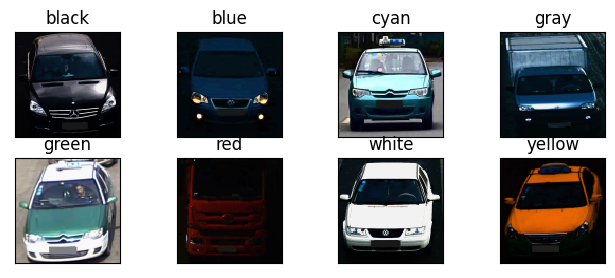

In [4]:
"""Print a random image per class"""
import matplotlib.pyplot as plt
import random
%matplotlib inline
fig = plt.figure(figsize=(8,3))
for i in range(8):
    
    ax = fig.add_subplot(2, 4, 1 + i, xticks=[], yticks=[])
    idx = random.choice(y[y==i].index)
    print(i,idx)
    features_idx = df[idx,::]
    #img_num = np.random.randint(features_idx.shape[0])
    #im = np.transpose(features_idx[img_num,::],(1,2,0))
    im = features_idx
    ax.set_title(d_b[i])
    plt.imshow(im[:,:,[2,1,0]],interpolation='nearest')
plt.show()

In [5]:
df=df.astype('float32')

In [6]:
"""Normalization of data. Note: a different normalization value will be required if using a color space apart from RGB"""
df=df/255

In [7]:
"""Train-test split"""
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)

y_train=to_categorical(y_train)
y_test=to_categorical(y_test)


In [8]:
"""create validation data of size 1000"""
X_val=X_train[:1000]
partial_X_train=X_train[1000:]
y_val=y_train[:1000]
partial_y_train=y_train[1000:]


In [9]:
from keras import models
from keras import layers
from keras import optimizers

#del network
from keras import backend as K

# Some memory clean-up
K.clear_session()


In [10]:
"""for description on Model architecture refer to project report"""
network = models.Sequential()
network.add(layers.Conv2D(32, kernel_size=(3,3),padding="same",input_shape=(100,100,3),activation="relu"))
network.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
network.add(layers.Conv2D(10, kernel_size=(2,2), activation='relu'))
network.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
network.add(layers.Flatten())
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dense(64, activation='relu'))

network.add(layers.Dense(8, activation='softmax'))


In [11]:
"""Compile using either RMSprop of SGD with momentum 0.9 (similar outputs)"""
network.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(),#SGD(momentum=0.9),
              metrics=['accuracy'])


In [12]:
"""Run for 30 epochs"""
history=network.fit(partial_X_train, partial_y_train, epochs=30,validation_data=(X_val,y_val))


Epoch 1/30
271/271 [==============================] - 28s 101ms/step - loss: 0.7609 - accuracy: 0.7267 - val_loss: 0.5437 - val_accuracy: 0.7970
Epoch 2/30
271/271 [==============================] - 27s 98ms/step - loss: 0.4065 - accuracy: 0.8480 - val_loss: 0.5127 - val_accuracy: 0.8110
Epoch 3/30
271/271 [==============================] - 27s 101ms/step - loss: 0.2932 - accuracy: 0.8917 - val_loss: 0.3752 - val_accuracy: 0.8720
Epoch 4/30
 58/271 [=====>........................] - ETA: 19s - loss: 0.2225 - accuracy: 0.9159

In [ ]:
"""check performance on test data """
test_loss, test_acc = network.evaluate(X_test, y_test)
print(test_loss, test_acc)
#hazy images
#5149/5149 [==============================] - 2s 422us/step
#0.916966989037365 0.8657991842266008
#haze free images
#4752/4752 [==============================] - 2s 358us/step
#0.7896632951005599 0.9126683501683501

In [ ]:
"""To visualize loss curves of training vs validation"""
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
"""re-train optimal model on entire training data """
K.clear_session()
network = models.Sequential()
network.add(layers.Conv2D(32, kernel_size=(3,3),padding="same",input_shape=(100,100,3),activation="relu"))
network.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
network.add(layers.Conv2D(10, kernel_size=(2,2), activation='relu'))
network.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
network.add(layers.Flatten())
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dense(64, activation='relu'))

network.add(layers.Dense(8, activation='softmax'))


network.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(),#SGD(momentum=0.9),
              metrics=['accuracy'])

history=network.fit(X_train, y_train, epochs=7)


In [ ]:
"""evaluate optimal model on test data"""
test_loss, test_acc = network.evaluate(X_test, y_test)
print(test_loss, test_acc)
#hazy
#5149/5149 [==============================] - 3s 596us/step
#0.36521502827458946 0.8813361817018387
#haze free
#4752/4752 [==============================] - 2s 499us/step
#0.31179774408338445 0.906986531986532

In [ ]:
"""Precision and recall per class"""
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = network.predict_classes(X_test)
print(classification_report(Y_test, y_pred,target_names=list(d.keys())))
""" 
              precision    recall  f1-score   support

       black       0.94      0.96      0.95      1150
        blue       0.97      0.87      0.92       381
        cyan       0.92      0.96      0.94        91
        gray       0.88      0.74      0.81       984
       green       0.97      1.00      0.98       181
         red       0.98      0.93      0.95       341
       white       0.85      0.96      0.90      1426
      yellow       0.95      0.95      0.95       198

   micro avg       0.91      0.91      0.91      4752
   macro avg       0.93      0.92      0.92      4752
weighted avg       0.91      0.91      0.90      4752
"""

In [ ]:
"""Optimal network summary"""
network.summary()

In [ ]:
"""Accuracy per class"""
test_acc=[]
for i in range(8):
    chk=np.array([np.argmax(y, axis=None, out=None)==i for y in y_test])
    test_acc.append(network.evaluate(X_test[chk,::],y_test[chk],verbose=0)[1])
    print(labels[i]," :: ",round(test_acc[i],2))
print(sum(test_acc)/len(test_acc))
"""black  ::  0.96
blue  ::  0.87
cyan  ::  0.96
gray  ::  0.74
green  ::  1.0
red  ::  0.93
white  ::  0.96
yellow  ::  0.95
0.9207616961659608"""

In [ ]:
"""Save model and weights"""
network.save('vehicle_color_haze_free_model.h5')
network.save_weights('vehicle_color_model_haze_free_weights.h5')


In [ ]:
"""The below cells try to look at intermediate outputs"""
layer_outputs = [layer.output for layer in network.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=network.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
print(len(layer_outputs))

In [ ]:
activations = activation_model.predict(X_test[5,::].reshape(1,100,100,3)) # Returns a list of five Numpy arrays: one array per layer activation
print("class:",d_b[np.argmax(activations[len(activations)-1])])
print(len(activations[0:8]))

In [ ]:
print(y_test[5])

In [ ]:
plt.imshow(X_test[5,::])

In [ ]:
j=0
for first_layer_activation in activations:
    fig = plt.figure(figsize=(24,6))
    j=j+1
    if(j>4):
        break
    for i in range(first_layer_activation.shape[3]):
        ax = fig.add_subplot(2, 16, 1 + i, xticks=[], yticks=[])
        plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis',interpolation='nearest')
        ax.set_title(i)
        #print(i)
    plt.show()